# Fairness and Bias Analysis of German Credit Dataset
**Author**: Dariel Johnuel Carrion  
**Date**: [10/10/2024]  

### Overview
This notebook aims to analyze the fairness and bias in the German Credit Dataset. We will:
- Load and preprocess the dataset.
- Define and apply a creditworthiness scoring formula.
- Evaluate the fairness metrics.
- Perform bias mitigation and analyze the results.

## Step 1: Import Necessary Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying plots inline
%matplotlib inline

## Step 2: Exploring the Dataset
### 2.1 Loading the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('GermanCreditData.csv')

### 2.2 Dataset Overview

In [3]:
# Display the first few rows
df.head()

,Account_Status,Duration,Credit_History,Purpose,Credit_Amount,Savings,Employment_Since,Installment_Rate,Personal_Status_Sex,Debtors,...,Property,Age,Other_Installment_Plans,Housing,Existing_Credits,Job,Liable_People,Telephone,Foreign_Worker,Class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
# Dataset dimensions
print(f'The dataset contains {df.shape[0]} observations and {df.shape[1]} variables.')


The dataset contains 1000 observations and 21 variables.


In [5]:
# Identify protected attributes
protected_attributes = ['Age', 'Personal_Status_Sex']
print(f'Protected Attributes: {protected_attributes}')


Protected Attributes: ['Age', 'Personal_Status_Sex']


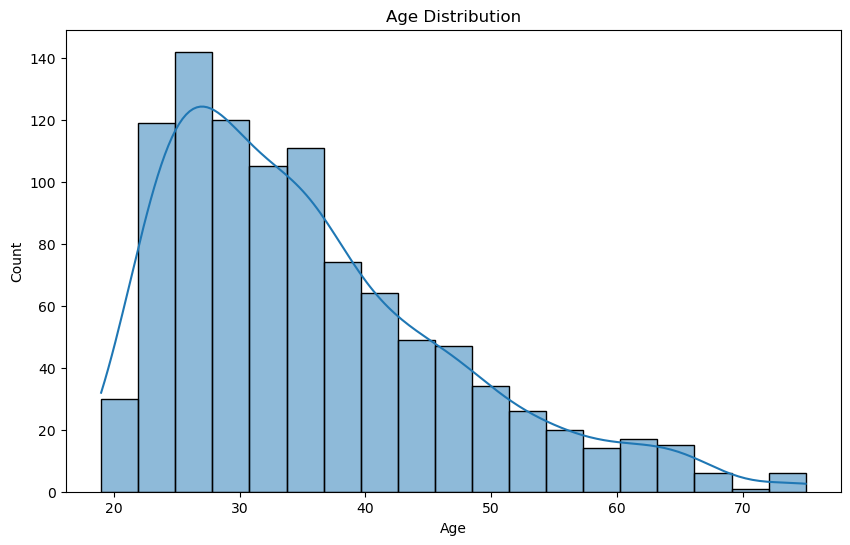

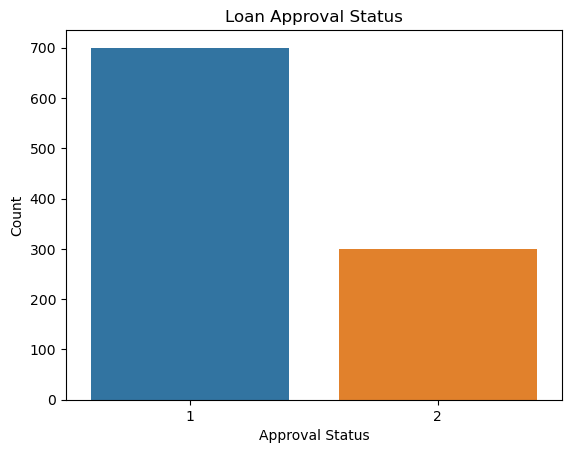

In [6]:
# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Visualize class imbalance
sns.countplot(data=df, x='Class')
plt.title('Loan Approval Status')
plt.xlabel('Approval Status')
plt.ylabel('Count')
plt.show()

## Step 3: Defining Creditworthiness and Preparing the Dataset
### 3.1 Dataset Outcome Variable


In [7]:
# Outcome variable is 'Class' where 1 = Approved, 2 = Denied
df['Class'].value_counts()


Class
1    700
2    300
Name: count, dtype: int64

### 3.2 Creditworthiness Formula


In [8]:
# Define the function to calculate creditworthiness
def calculate_creditworthiness(row):
    score = 0
    
    # Credit History
    credit_history_scores = {
        'A30': 20,  # No credits taken / All credits paid back duly
        'A31': 15,  # All credits at this bank paid back duly
        'A32': 10,  # Existing credits paid back duly till now
        'A33': 5,   # Delay in paying off in the past
        'A34': 0    # Critical account / Other credits existing
    }
    score += credit_history_scores.get(row['Credit_History'], 0)
    
    # Credit Amount (lower amount is better)
    if row['Credit_Amount'] <= 2000:
        score += 20
    elif row['Credit_Amount'] <= 5000:
        score += 15
    elif row['Credit_Amount'] <= 10000:
        score += 10
    else:
        score += 5
    
    # Duration in months (shorter duration is better)
    if row['Duration'] <= 12:
        score += 15
    elif row['Duration'] <= 24:
        score += 10
    elif row['Duration'] <= 36:
        score += 5
    else:
        score += 0
    
    # Employment Since
    employment_scores = {
        'A71': 0,   # Unemployed
        'A72': 5,   # < 1 year
        'A73': 10,  # 1 <= ... < 4 years
        'A74': 15,  # 4 <= ... < 7 years
        'A75': 20   # >= 7 years
    }
    score += employment_scores.get(row['Employment_Since'], 0)
    
    # Savings
    savings_scores = {
        'A61': 5,   # ... < 100 DM
        'A62': 10,  # 100 <= ... < 500 DM
        'A63': 15,  # 500 <= ... < 1000 DM
        'A64': 20,  # .. >= 1000 DM
        'A65': 0    # Unknown / No savings account
    }
    score += savings_scores.get(row['Savings'], 0)
    
    # Existing Credits at this bank
    if row['Existing_Credits'] == 1:
        score += 10
    elif row['Existing_Credits'] == 2:
        score += 5
    else:
        score += 0
    
    # Installment Rate (lower is better)
    if row['Installment_Rate'] <= 2:
        score += 10
    elif row['Installment_Rate'] <= 4:
        score += 5
    else:
        score += 0
    
    return score

# Apply the creditworthiness function to the dataset
df['Creditworthiness'] = df.apply(calculate_creditworthiness, axis=1)


### 3.3 Selecting Protected Class Attribute
Protected attribute is 'Age'
We will use 'Age' to define privileged and unprivileged groups


### 3.4 Defining Privileged and Unprivileged Groups


In [9]:
# Define function to assign privilege group based on age
def define_privilege(row):
    if 25 <= row['Age'] <= 60:
        return 'Privileged'
    else:
        return 'Unprivileged'

# Apply the function to create a new column
df['Privilege_Group'] = df.apply(define_privilege, axis=1)

# Check the distribution of the privilege groups
df['Privilege_Group'].value_counts()


Privilege_Group
Privileged      806
Unprivileged    194
Name: count, dtype: int64

### 3.5 Splitting the Dataset


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (50% each)
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

# Report counts in training set
privileged_train = train_df[train_df['Privilege_Group'] == 'Privileged'].shape[0]
unprivileged_train = train_df[train_df['Privilege_Group'] == 'Unprivileged'].shape[0]

print(f'Privileged Group in Training Set: {privileged_train}')
print(f'Unprivileged Group in Training Set: {unprivileged_train}')


Privileged Group in Training Set: 407
Unprivileged Group in Training Set: 93


## Step 4: Maximizing Profit
### 4.1 Creditworthiness Histogram

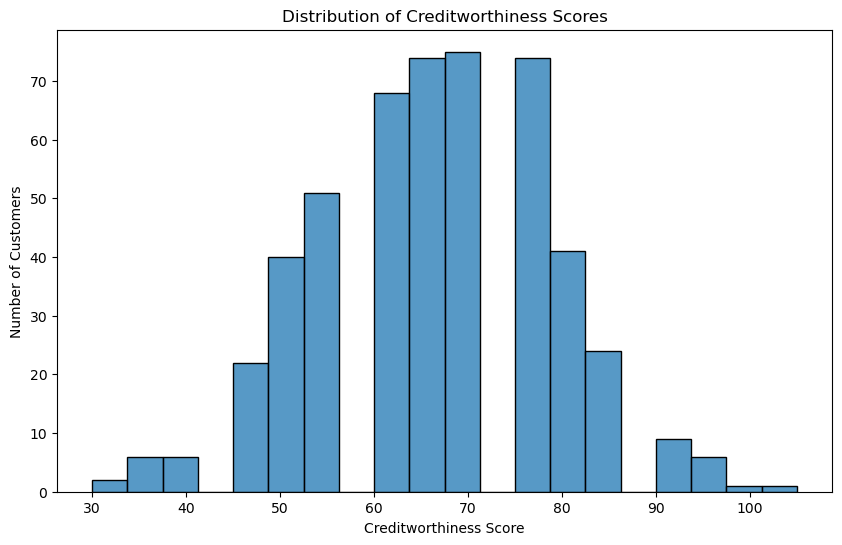

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(train_df['Creditworthiness'], bins=20, kde=False, edgecolor='k')
plt.title('Distribution of Creditworthiness Scores')
plt.xlabel('Creditworthiness Score')
plt.ylabel('Number of Customers')
plt.show()

### 4.2 Determining Optimal Threshold


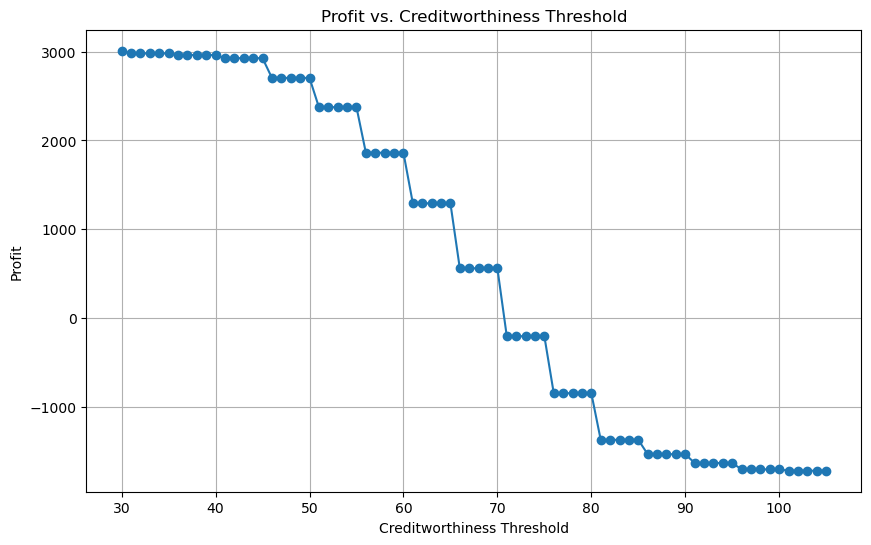

In [12]:
def calculate_profit(threshold):
    profit = 0
    for index, row in train_df.iterrows():
        actual = int(row['Class'])
        predicted = 1 if row['Creditworthiness'] >= threshold else 2

        if actual == 1 and predicted == 1:
            profit += 10
        elif actual == 1 and predicted == 2:
            profit -= 5
        elif actual == 2 and predicted == 1:
            profit -= 3
        # No profit change when both actual and predicted are 2
    return profit

# Determine the range of creditworthiness scores
min_score = int(train_df['Creditworthiness'].min())
max_score = int(train_df['Creditworthiness'].max())

# Iterate over possible thresholds
thresholds = range(min_score, max_score + 1)
profits = [calculate_profit(t) for t in thresholds]

# Plot Profit vs Threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, profits, marker='o')
plt.title('Profit vs. Creditworthiness Threshold')
plt.xlabel('Creditworthiness Threshold')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

## Step 5: Threshold Selection and Fairness Metrics
### Visualizing Profit vs. Threshold
Note: We will use Statistical Parity Difference and Disparate Impact Ratio

This step helps you visualize how profit varies with different thresholds, enabling you to identify the threshold that offers a balance between maximizing profit and maintaining fairness.


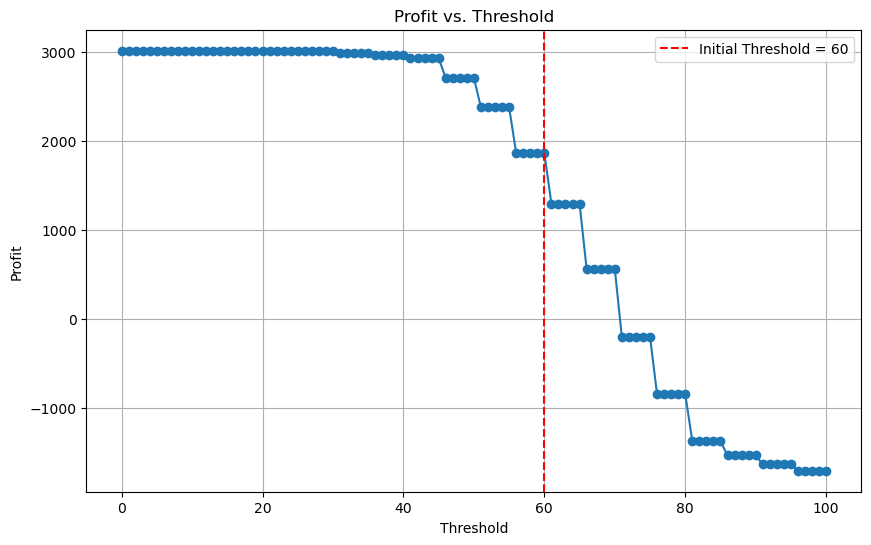

In [13]:
# Define a function to calculate profit at different thresholds
def calculate_profit(threshold):
    profit = 0
    for index, row in train_df.iterrows():
        actual = int(row['Class'])
        predicted = 1 if row['Creditworthiness'] >= threshold else 2

        if actual == 1 and predicted == 1:
            profit += 10  # True positive profit
        elif actual == 1 and predicted == 2:
            profit -= 5  # False negative loss
        elif actual == 2 and predicted == 1:
            profit -= 3  # False positive loss
    return profit

# Visualize profit vs. threshold
import matplotlib.pyplot as plt

thresholds = range(0, 101)
profits = [calculate_profit(th) for th in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, marker='o')
plt.axvline(60, color='red', linestyle='--', label='Initial Threshold = 60')
plt.title('Profit vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.show()


### 5.2: Selecting the Optimal Threshold
After analyzing the profit curve, you can select the threshold that aligns with the desired balance between profit and fairness.

In [14]:
# Select practical threshold (e.g., threshold where profit is close to maximum but not at zero)
optimal_threshold = 60  # Adjust based on the plot
print(f"Selected Optimal Threshold: {optimal_threshold}")

# Recalculate maximum profit at the selected threshold
max_profit = calculate_profit(optimal_threshold)
print(f"Maximum Profit at Optimal Threshold: {max_profit}")


Selected Optimal Threshold: 60
Maximum Profit at Optimal Threshold: 1862


### Step 5.3: Computing Fairness Metrics

Now that the **optimal threshold** has been selected, visualize the distribution of Creditworthiness scores with the selected threshold before calculating fairness metrics.

#### 5.3.1: Visualizing the Selected Threshold on Creditworthiness Distribution


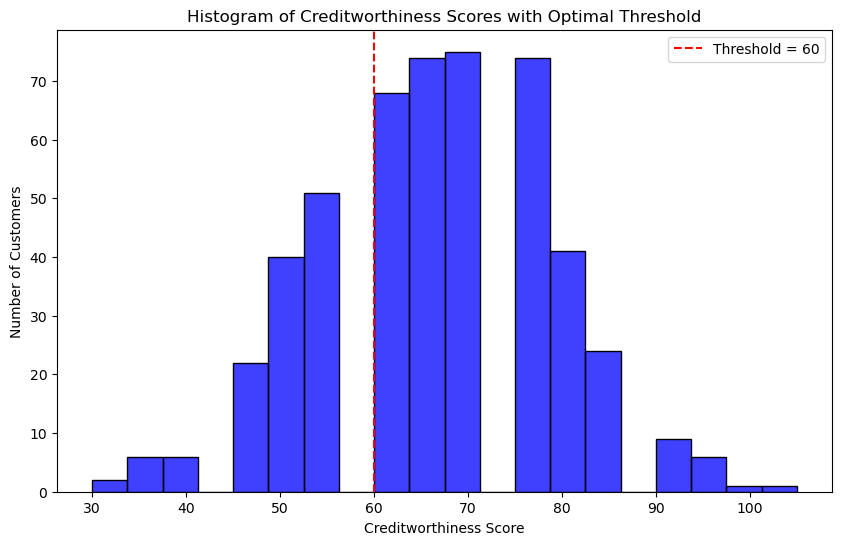

In [15]:
# Visualize the distribution of Creditworthiness scores with the selected threshold
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Creditworthiness'], bins=20, kde=False, color='blue')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Threshold = {optimal_threshold}')
plt.title('Histogram of Creditworthiness Scores with Optimal Threshold')
plt.xlabel('Creditworthiness Score')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()


#### 5.3.2: Computing Fairness Metrics

With the threshold selected, we calculate fairness metrics to assess bias.


In [16]:
def compute_fairness_metrics(df, threshold):
    df_copy = df.copy()
    df_copy['Predicted_Class'] = df_copy['Creditworthiness'].apply(lambda x: 1 if x >= threshold else 2)
    
    privileged = df_copy[df_copy['Privilege_Group'] == 'Privileged']
    unprivileged = df_copy[df_copy['Privilege_Group'] == 'Unprivileged']
    
    p_privileged = sum(privileged['Predicted_Class'] == 1) / len(privileged)
    p_unprivileged = sum(unprivileged['Predicted_Class'] == 1) / len(unprivileged)
    
    statistical_parity_difference = p_unprivileged - p_privileged
    disparate_impact_ratio = p_unprivileged / p_privileged if p_privileged != 0 else 0
    
    return statistical_parity_difference, disparate_impact_ratio


In [17]:
# Compute metrics at the optimal threshold
spd, dir_ratio = compute_fairness_metrics(train_df, optimal_threshold)

print(f'Statistical Parity Difference: {spd}')
print(f'Disparate Impact Ratio: {dir_ratio}')


Statistical Parity Difference: 0.03463580882935724
Disparate Impact Ratio: 1.0468331368556425


#### 5.3.3: Documenting Fairness Metrics

Explain the meaning of the computed fairness metrics and evaluate whether they indicate bias:

- **Statistical Parity Difference (SPD):** Measures the difference in positive prediction rates between unprivileged and privileged groups. A value close to 0 indicates fairness.
- **Disparate Impact Ratio (DIR):** The ratio of positive prediction rates between unprivileged and privileged groups. Values between 0.8 and 1.25 are generally considered acceptable.


In [18]:
# Acceptable ranges:
# Statistical Parity Difference: [-0.1, 0.1]
# Disparate Impact Ratio: [0.8, 1.25]

# Determine if bias is indicated
spd_bias = 'Yes' if abs(spd) > 0.1 else 'No'
dir_bias = 'Yes' if dir_ratio < 0.8 or dir_ratio > 1.25 else 'No'

# Display results
print(f"Metric: Statistical Parity Difference")
print(f"Value: {spd}")
print(f"Indicates Bias: {spd_bias}")

print(f"\nMetric: Disparate Impact Ratio")
print(f"Value: {dir_ratio}")
print(f"Indicates Bias: {dir_bias}")


Metric: Statistical Parity Difference
Value: 0.03463580882935724
Indicates Bias: No

Metric: Disparate Impact Ratio
Value: 1.0468331368556425
Indicates Bias: No


In [25]:
# Apply the threshold to classify approvals
df['Predicted_Class'] = df['Creditworthiness'].apply(lambda x: 1 if x >= 60 else 2)

# Create a table of results
group_outcomes = df.groupby(['Privilege_Group', 'Predicted_Class']).size().unstack()

# Rename columns for better readability
group_outcomes.columns = ['Favorable (Approved)', 'Unfavorable (Declined)']
print(group_outcomes)


                 Favorable (Approved)  Unfavorable (Declined)
Privilege_Group                                              
Privileged                        596                     210
Unprivileged                      160                      34


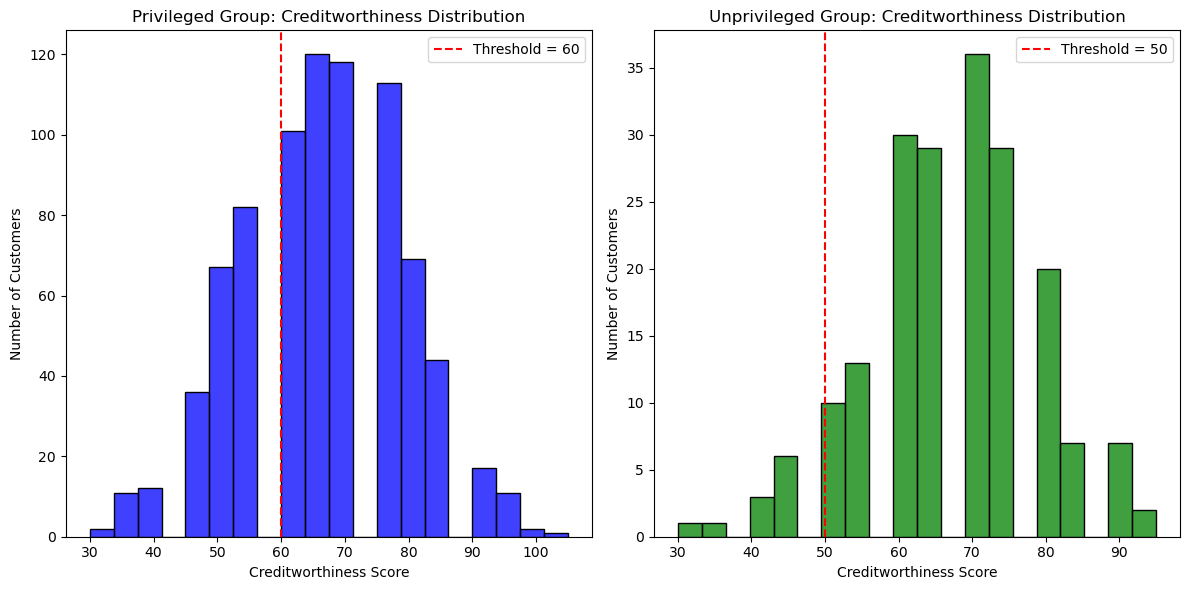

In [26]:

# Assuming you have already loaded and preprocessed your dataset as 'df'
# Also assuming you have a 'Creditworthiness' column and a 'Privilege_Group' column

# Set the thresholds for privileged and unprivileged groups
privileged_threshold = 60
unprivileged_threshold = 50

# Create subplots to compare good vs bad credit risk for both privileged and unprivileged groups
plt.figure(figsize=(12, 6))

# Privileged group histogram
plt.subplot(1, 2, 1)
sns.histplot(data=df[df['Privilege_Group'] == 'Privileged'], x='Creditworthiness', bins=20, kde=False, color='blue', edgecolor='k')
plt.axvline(privileged_threshold, color='red', linestyle='--', label=f'Threshold = {privileged_threshold}')
plt.title('Privileged Group: Creditworthiness Distribution')
plt.xlabel('Creditworthiness Score')
plt.ylabel('Number of Customers')
plt.legend()

# Unprivileged group histogram
plt.subplot(1, 2, 2)
sns.histplot(data=df[df['Privilege_Group'] == 'Unprivileged'], x='Creditworthiness', bins=20, kde=False, color='green', edgecolor='k')
plt.axvline(unprivileged_threshold, color='red', linestyle='--', label=f'Threshold = {unprivileged_threshold}')
plt.title('Unprivileged Group: Creditworthiness Distribution')
plt.xlabel('Creditworthiness Score')
plt.ylabel('Number of Customers')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Step 6: Bias Mitigation

#### 6.1: Adjusting Thresholds

To mitigate bias, apply different thresholds for privileged and unprivileged groups.


In [19]:
# Adjust thresholds for bias mitigation
privileged_threshold = optimal_threshold  # 60
unprivileged_threshold = optimal_threshold - 10  # Adjust delta as needed (e.g., 10)

print(f"Privileged Threshold: {privileged_threshold}")
print(f"Unprivileged Threshold: {unprivileged_threshold}")


Privileged Threshold: 60
Unprivileged Threshold: 50


#### 6.2: Apply Adjusted Thresholds

Using the adjusted thresholds to compute new predictions.


In [20]:
def apply_group_threshold(row):
    if row['Privilege_Group'] == 'Privileged':
        threshold = privileged_threshold
    else:
        threshold = unprivileged_threshold
    return 1 if row['Creditworthiness'] >= threshold else 2

train_df['Adjusted_Predicted_Class'] = train_df.apply(apply_group_threshold, axis=1)


#### 6.3: Calculate Adjusted Profit

Calculate the profit using the adjusted thresholds.


In [21]:
def calculate_adjusted_profit():
    profit = 0
    for index, row in train_df.iterrows():
        actual = int(row['Class'])
        predicted = row['Adjusted_Predicted_Class']

        if actual == 1 and predicted == 1:
            profit += 10
        elif actual == 1 and predicted == 2:
            profit -= 5
        elif actual == 2 and predicted == 1:
            profit -= 3
    return profit

adjusted_profit = calculate_adjusted_profit()
print(f'Adjusted Profit after Bias Mitigation: {adjusted_profit}')


Adjusted Profit after Bias Mitigation: 1949


#### 6.4: Recompute Fairness Metrics After Mitigation

Recalculate fairness metrics using the adjusted predictions.


In [22]:
def compute_adjusted_fairness_metrics(df):
    df_copy = df.copy()
    df_copy['Predicted_Class'] = df_copy['Adjusted_Predicted_Class']

    privileged = df_copy[df_copy['Privilege_Group'] == 'Privileged']
    unprivileged = df_copy[df_copy['Privilege_Group'] == 'Unprivileged']

    p_privileged = sum(privileged['Predicted_Class'] == 1) / len(privileged)
    p_unprivileged = sum(unprivileged['Predicted_Class'] == 1) / len(unprivileged)

    statistical_parity_difference = p_unprivileged - p_privileged
    disparate_impact_ratio = p_unprivileged / p_privileged if p_privileged != 0 else 0

    return statistical_parity_difference, disparate_impact_ratio

# Compute adjusted fairness metrics
spd_adjusted, dir_ratio_adjusted = compute_adjusted_fairness_metrics(train_df)

print(f'Adjusted Statistical Parity Difference: {spd_adjusted}')
print(f'Adjusted Disparate Impact Ratio: {dir_ratio_adjusted}')


Adjusted Statistical Parity Difference: 0.17442075506591637
Adjusted Disparate Impact Ratio: 1.235844675454578


## Step 7: Post Bias Mitigation Analysis
* Compare the original profit and adjusted profit.
* Discuss how the fairness metrics changed after bias mitigation.
* Analyze the trade-off between profit and fairness.

## Optional: Save Your Results


In [23]:
# Save the training data with predictions to a CSV file (optional)
train_df.to_csv('train_df_with_predictions.csv', index=False)
